# Exploring Data Preprocessing

I want to take our gait time series data and denoise/filter it to produce clean data for an LSTM.

In [1]:
#Dependancies
import sys, os, errno
import numpy as np
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

x    0.986119
y    0.057747
z   -0.028333
dtype: float64
x   -1.095262e-15
y    1.408346e-14
z    1.155467e-14
dtype: float64


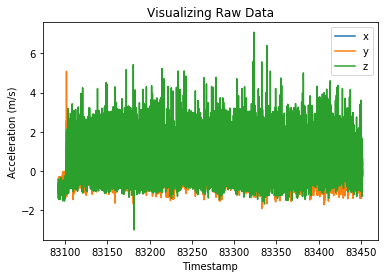

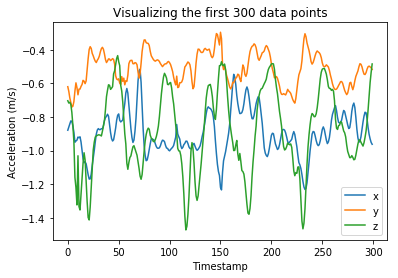

In [2]:
#We're going to work with example gait data from a single six minute walk test randomly selected from Sherlock
#Healthcode 8382332
healthcode = '8382332'
directory = 'C:/Users/dwubu/Desktop/6mwtData/' + healthcode + '.json';
raw_data = pd.read_json(directory).set_index('timestamp')
#normalize
print(raw_data.mean())
raw_data = raw_data - raw_data.mean()
print(raw_data.mean())
#Visualize the data
plt.figure()
plt.plot(raw_data.x, label="x")
plt.plot(raw_data.y, label="y")
plt.plot(raw_data.z, label="z")
plt.title("Visualizing Raw Data")
plt.xlabel("Timestamp")
plt.ylabel("Acceleration (m/s)")
plt.legend()
plt.show()

#Visualize a slice
plt.figure()
plt.plot(raw_data.x.get_values()[0:300], label="x")
plt.plot(raw_data.y.get_values()[0:300], label="y")
plt.plot(raw_data.z.get_values()[0:300], label="z")
plt.title("Visualizing the first 300 data points")
plt.xlabel("Timestamp")
plt.ylabel("Acceleration (m/s)")
plt.legend()
plt.show()


# Bhargav's approach: Time windows
Bhargav broke each walk test into a collection of short, overlapping, time windows.

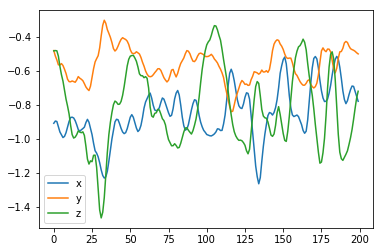

In [3]:
# Set overlap to the amount you want the sliding windows to have in common, in ms
def moving_window(accelx, length, overlap, step=1):
    streams = it.tee(accelx, length)
    return zip(*[it.islice(stream, i, None, step + overlap) for stream, i in zip(streams, it.count(step=step))])

def normalize_dataset(data):
    return (data - np.average(data))

def create_dataframes(num_of_ms, overlap):

    #Put into array form
    x = np.asarray(raw_data.x)
    y = np.asarray(raw_data.y)
    z = np.asarray(raw_data.z)
        
    x_ = list(moving_window(x, num_of_ms, overlap))
    y_ = list(moving_window(y, num_of_ms, overlap))
    z_ = list(moving_window(z, num_of_ms, overlap))
    df = pd.DataFrame({'healthCode': healthcode, 
                           'xwindows': x_, 'ywindows': y_, 'zwindows': z_}, columns=['healthCode', 'xwindows', 
                           'ywindows', 'zwindows']).set_index('healthCode')
    
    return df

windows = create_dataframes(200, 99)

#Visualize a single window
myIter = windows.iterrows()
next(myIter)
next(myIter)
#next(myIter)
firstWindow = next(myIter)[1]

plt.figure()
plt.plot(firstWindow['xwindows'], label="x")
plt.plot(firstWindow['ywindows'], label="y")
plt.plot(firstWindow['zwindows'], label="z")
plt.legend()
plt.show()

# New Preprocessing
Here, Bhargav just did feature extraction and used kNN and Random Forest Classifiers. We want to keep some element of time in our model, and just train RNN/LSTMs.

First, we want to denoise, using a butterworth bandpass filter.
*Some internets indicate this filter is bad/removes useful info?

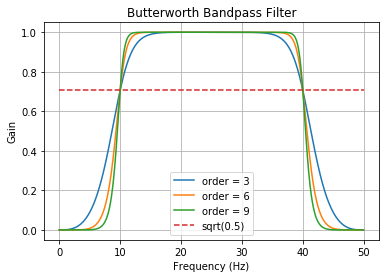

In [4]:
# =============================================================================
# Functions for applying the bandpass filter
# =============================================================================

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# =============================================================================
# Show what the filter looks like
# =============================================================================
from scipy.signal import freqz


# Sample rate and desired cutoff frequencies (in Hz).
fs = 100.0
lowcut = 10.0
highcut = 40.0

# Plot the frequency response for a few different orders.
plt.figure()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.title('Butterworth Bandpass Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend()

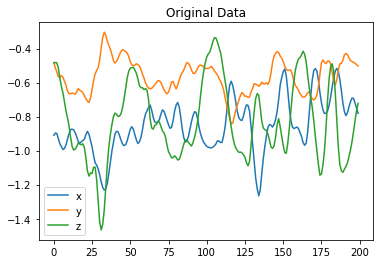

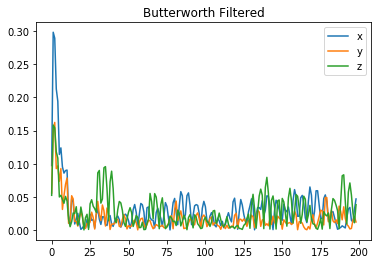

In [5]:
#Apply Butterworth filter

#Print original data    
plt.figure()
plt.title("Original Data")
plt.plot(firstWindow['xwindows'], label = 'x')
plt.plot(firstWindow['ywindows'], label = 'y')
plt.plot(firstWindow['zwindows'], label = 'z') 
plt.legend()   
plt.show()


#Extract data
x = firstWindow['xwindows']
y = firstWindow['ywindows']
z = firstWindow['zwindows']

#Apply butterfield window 
#SIGNAL PROCESS fs = 1000, highcut = 190?
lowcut = 10
highcut = 40
fs = 100.0

x = butter_bandpass_filter(x, lowcut, highcut, fs)
y = butter_bandpass_filter(y, lowcut, highcut, fs)
z = butter_bandpass_filter(z, lowcut, highcut, fs)


plt.figure()
plt.title("Butterworth Filtered")
plt.plot(abs(x[1:]), label = 'x')
plt.plot(abs(y[1:]), label = 'y')
plt.plot(abs(z[1:]), label = 'z')
plt.legend()
plt.show()

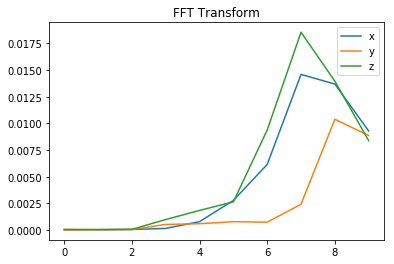

In [6]:
# =============================================================================
# We can frequency transform the data
# =============================================================================

def hann(window):
    '''
    hann
    Applies a hanning window function to the passed vector
    '''
    return np.hanning(len(window))*window


#Frequency transformed data, hann windowed
x = np.fft.fft(hann(x))
y = np.fft.fft(hann(y))
z = np.fft.fft(hann(z))

plt.figure()
plt.title("FFT Transform")
plt.plot(abs(x[:10]), label = 'x')
plt.plot(abs(y[:10]), label = 'y')
plt.plot(abs(z[:10]), label = 'z')
plt.legend()
plt.show()



#plt.figure()
#plt.title("Inverse Transform")
#plt.plot(abs(np.fft.ifft(x)))
#plt.plot(abs(np.fft.ifft(y)))
#plt.plot(abs(np.fft.ifft(z)))
#plt.show()

#final_data = pd.Dataframe


#  Dynamic window creation
Observation: The data above is disgusting. This may be because fft wraps the end of the window to the start, and treats it as one period. This also leads to peaks on the side.

We want to make better windows - perhaps by identifying strides. We can just consider the entire 6 minutes, or dynamically create windows with a certain number of strides so that the "period" teased out by fft is consistent.
Question: How do we pick which strides are correct? Can we do data filtering here, and exclude data? What do we do if peaks are not in z?

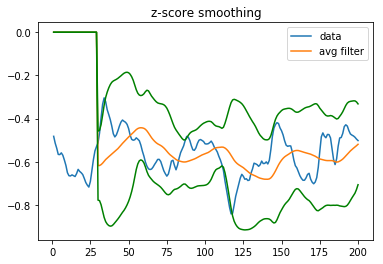

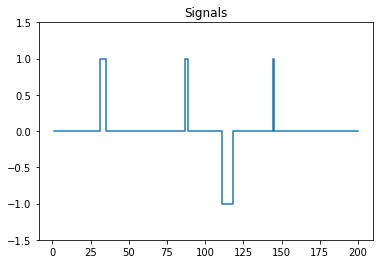

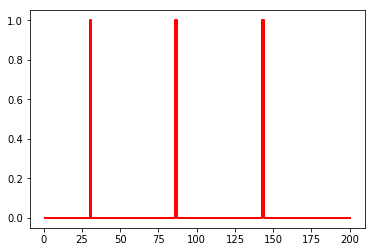

In [7]:
# =============================================================================
# Using Smoothed z-score algorithm to identify peaks
# =============================================================================
# Implementation of algorithm from https://stackoverflow.com/a/22640362/6029703

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))
    
    
    
def findPeaks(data):
    '''
    My original function to produce a vector of positive extreme locations
    '''
    # Settings: lag = 30, threshold = 4, influence = 0
    lag = 30
    threshold = 2
    influence = 1
    
    # Run algo with settings from above
    result = thresholding_algo(data, lag=lag, threshold=threshold, influence=influence)
    
    filteredData = result["signals"]
    
    maxima = []
    
    for i in range(len(filteredData) - 1):
        #Check if this is the first i
        if filteredData[i] != 1 and filteredData[i+1] == 1:
            maxima.append(i + 1)
            
    return maxima
    

# =============================================================================
# Demonstrate Smoothed Z-score
# =============================================================================
lag = 30
threshold = 2.5
influence = 1

#Get data
#x = np.asarray(raw_data.x)
#y = np.asarray(raw_data.y)
#z = np.asarray(raw_data.z)

y = firstWindow['ywindows']
#y = np.asarray(raw_data.z)

# Run algo with settings from above
result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)
    

#plot algorithm
plt.figure()
plt.plot(np.arange(1, len(y)+1), y, label='data')
plt.plot(np.arange(1, len(y)+1),
               result["avgFilter"], label='avg filter')
    
plt.plot(np.arange(1, len(y)+1),
               result["avgFilter"] + threshold * result["stdFilter"], color="green")
    
plt.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green")
plt.legend()
plt.title('z-score smoothing')

#Plot signals
plt.figure()
plt.step(np.arange(1, len(y)+1), result["signals"])
plt.title('Signals')
plt.ylim(-1.5, 1.5)

#Plot only positive peaks    
filteredData = [0]*len(y)
peaks = findPeaks(y)
    
for i in range(len(y)):
    if i in peaks:
        filteredData[i] = 1
        
plt.figure()
plt.step(np.arange(1, len(y)+1), filteredData, color="red", lw=2)
plt.show()


Peaks found via smoothed z-score on z-axial acceleometry
[38, 90, 136, 188, 295, 356, 452, 661, 722, 771, 872, 923, 931, 993, 1010, 1047, 1110, 1148, 1153, 1232, 1258, 1337, 1360, 1432, 1469, 1537, 1545, 1574, 1638, 1676, 1745, 1779, 1843, 1883, 1953, 1986, 2055, 2089, 2158, 2193, 2261, 2300, 2370, 2406, 2475, 2510, 2577, 2616, 2683, 2721, 2785, 2821, 2823, 2893, 2927, 2993, 3026, 3097, 3133, 3197, 3236, 3308, 3341, 3412, 3449, 3515, 3552, 3621, 3658, 3761, 3826, 3864, 3943, 3968, 4036, 4074, 4143, 4153, 4178, 4283, 4350, 4383, 4387, 4456, 4468, 4493, 4562, 4599, 4677, 4704, 4772, 4809, 4877, 4913, 4979, 5016, 5084, 5116, 5121, 5192, 5202, 5228, 5295, 5331, 5399, 5435, 5502, 5540, 5606, 5647, 5729, 5752, 5819, 5830, 5858, 5922, 5957, 5961, 6066, 6170, 6237, 6274, 6355, 6380, 6449, 6460, 6484, 6552, 6589, 6653, 6656, 6693, 6755, 6794, 6856, 6899, 6967, 6975, 7002, 7081, 7107, 7172, 7204, 7210, 7313, 7382, 7414, 7418, 7522, 7588, 7626, 7705, 7727, 7730, 7794, 7827, 7832, 7911, 7937, 8005

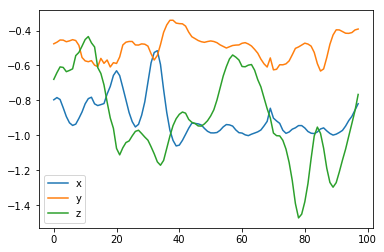

Text(0.5,0,'Time steps')

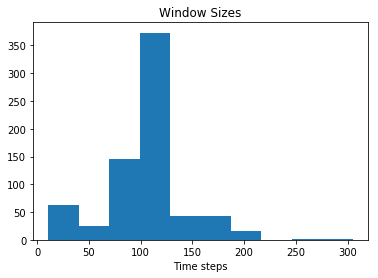

In [8]:
# =============================================================================
# Build dynamic windows
# =============================================================================

def create_dataframes(steps_per_frame):
    

    #Put into array form
    x = np.asarray(raw_data.x)
    y = np.asarray(raw_data.y)
    z = np.asarray(raw_data.z)
    
    #Using z as metric
    peaks = findPeaks(z)
        
    x_ = []
    y_ = []
    z_ = []
        
    print('Peaks found via smoothed z-score on z-axial acceleometry')
    print(peaks)
        
    for i in range(len(peaks) - steps_per_frame):
        #Insert some check for peak validity here?
        x_.append(x[ peaks[i] : peaks[i + steps_per_frame] ]) 
        y_.append(y[ peaks[i] : peaks[i + steps_per_frame] ]) 
        z_.append(z[ peaks[i] : peaks[i + steps_per_frame] ]) 

    df = pd.DataFrame({'healthCode': healthcode, 
                       'xwindows': x_, 'ywindows': y_, 'zwindows': z_}, columns=['healthCode', 'xwindows', 
                       'ywindows', 'zwindows']).set_index('healthCode')
    
    return peaks, df

# =============================================================================
# Demonstrate function
# =============================================================================
peaks, windows = create_dataframes(2)

#Visualize a single window
myIter = windows.iterrows()
#next(myIter)
#next(myIter)
#next(myIter)
firstWindow = next(myIter)[1]

plt.figure()
plt.plot(firstWindow['xwindows'], label="x")
plt.plot(firstWindow['ywindows'], label="y")
plt.plot(firstWindow['zwindows'], label="z")
plt.legend()
plt.show()

#Plot window sizes
sizes = []

for i in range(len(peaks) - 2):
    sizes.append(peaks[i + 2] - peaks[i])
               
plt.figure()
plt.hist(sizes)
plt.title("Window Sizes")
plt.xlabel("Time steps")
    

In [9]:
# =============================================================================
# At some point, save to a file
# =============================================================================
#final_data = pd.Dataframe(.....)

if(False):
    final_directory_str = window_directory_str + "/Processed"
    final_directory = os.fsencode(window_directory)
    if not os.path.exists(final_directory.decode()):          
        os.makedirs(final_directory.decode())
    
    final_data.to_hdf(final_directory.decode() + '/' + filename +'.h5', key='df', mode='w')


# Future Ideas
Just exclude strides that take too long? Currently vastly underestimating steps.

Implement more complicated stride identification algorithms?
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4030415/